In [1]:
#from __future__ import division # uncomment this if using Python 2.7
import numpy as np
import math
from scipy import signal, spatial
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import data, color, img_as_float, img_as_ubyte, filters, feature, util
from sklearn import metrics
import pprint as pprint

%matplotlib inline
from IPython.display import HTML, display

# Feature matching



In this lab we are going to implement image matching based on features correspondances. We consider the simplest situation possible: the image pairs we consider are related by simple transformations, therefore we will make the following choices:
1. Feature detector: corners (with the shi-tomasi algorithm)
2. Feature description: patches around the corner (size $w\times w$)
3. Matching strategy: affinity matrix with a similarity measure of choice


The parameters of every intermediate step, must be specified as input arguments. Try with different distance metrics (e.g. euclidean, correlation, squared euclidean) and with all three image pairs (Rubik, Shrub, Phone)

## Let us define the main functions

We first write a function that extracts patches of image around each corner (w.r.t. the patch size, that is a parameter)
* First we need to pad our image, adding a surrounding frame of appropriate width. In this way even border features (like the red one in the drawing) will have their neighbourhood

Then, for each corner, 
* we adjust the corner coordinates with respect to the new padded image I_ext
* we extract the size_w X size_w patch surrounding the corner (check the range notation)
* we flatten the patch to form a 1D feature vector of size 2*size_w and save it in a list


<img src="week2_lab_notes.png" width="500">

In [2]:
def patch_descriptor(I, corner_pos, size_w):
    """Extract square patches around each corner on an input grayscale image. 
    - I: input RGB image
    - corner_pos: list with position of n corners (row,col)
    - size_w: (integer) patch side
   """
    
    n =len(corner_pos) ### FILL HERE to compute the nmber of corners
    hw = int(np.floor(size_w/2)) # half size of the patch (useful to center the patch)
    I_ext = util.pad(I, hw, 'reflect') # pad the image with a frame of width hw 
    
    # initialize patches list
    patches = np.zeros([n,(2*hw+1)**2])
    
    for i in range(0, n):
        
        r = corner_pos[i,0]+hw # adjust the row of each corner considering the padding
        c = corner_pos[i,1]+hw # do the same for the column 
        tmp = I_ext[r-hw:r+hw+1,c-hw:c+hw+1] ### FILL HERE (see the sketch above)
        patches[i,:] = tmp.flatten() #flatten the patch and save it in the patches list
        
    return patches
4

4

Implement the function that computes the feature matching procedure.
Assuming we have $m$ features in image 1 and $n$ features in image 2, the affinity matrix will have size $m\times n$.
For each feature in image 1, we will be matching the one in image 2 <i>minimizes</i> the distance.

Below you find a simple version of the procedure  
1. First compute the affinity matrix 
2. Then detect the maxima of the affinity matrix
3. Derive che corresponding matches
4. Return the matches and the affinity matrix

**Hint:** First check <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html">`spatial.distance.cdist`</a> from `scipy` module, with Euclidean metric.
Then use the formulae below to compute the elements of an affinity matrix (values in the range [0,1]
$\exp^{-d(f_i,g_j)/2\sigma^2}$ ) 



In [3]:
# def spectral_matching(sigma, patches1, patches2,corner_pos1,corner_pos2):

In [4]:
def spectral_matching(sigma, patches1, patches2,corner_pos1,corner_pos2):    
    # evaluate the distance among patches
    D = spatial.distance.cdist(patches1,patches2, metric='euclidean') ### FILL HERE (see the Hint above)
    # compute the affinity matrix using the exponent formulation
    E = np.exp(-D/(2*sigma**2)) ### FILL HERE (see the Hint above)
    # find the minimum distace
    argmaxE = np.argmax(E, axis=1)
    # plot the matching pairs
    match = corner_pos1[argmaxE,:]
#     print(E)
#     print(match)
    
    return E, match



Here you have a function that plots the images side-by-side and superimposes the features and a line connecting the matched pairs 

In [107]:
def show_match(match,corner_pos1,corner_pos2,img1, img2):
    """show match on side-by-side images"""
    
    img= np.concatenate([img1,img2],axis=1)
    plt.imshow(img, cmap=cm.gist_gray)
    
    for i in range(0, len(corner_pos1)):
        plt.plot([corner_pos1[i,1], match[i,1]+img1.shape[1]], [corner_pos1[i,0], match[i,0]],'y')
        
    plt.scatter(corner_pos1[:,1], corner_pos1[:,0], s=10, c='r')
    plt.scatter(corner_pos2[:,1]+img1.shape[1], corner_pos2[:,0], s=20, c='b')
    
    return img    

## Let us test the feature matching pipeline

We start with a simple image pair (shrub_L.jpg and shrub_R.jpg) related by a small translation. We first load the images, turn them to gray and visualize them

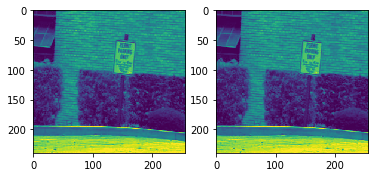

In [108]:
# LOAD IMAGES and turn them to gray
RGBimg1 = data.imread("images/shrub_L.jpg") ## FILL HERE
img1 = color.rgb2gray(RGBimg1) ## FILL HERE

RGBimg2 =data.imread("images/shrub_R.jpg") ## FILL HERE
img2 = color.rgb2gray(RGBimg2) ## FILL HERE


plt.subplot(1,2,1)
plt.imshow(img1)

plt.subplot(1,2,2)
plt.imshow(img2)

Now, let us identify the corners by using the shi tomasi algorithm implemented in skimage. Then we call our functions for patch description and feature matching. 

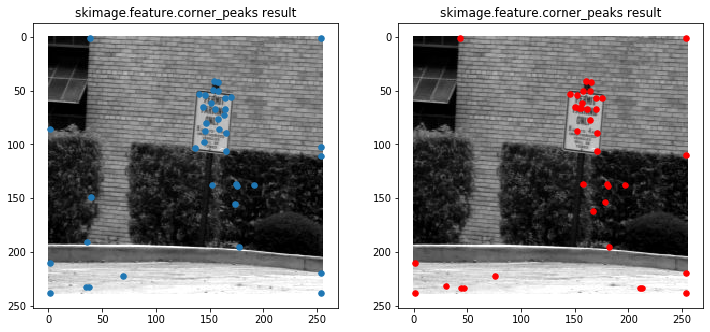

In [109]:
# FEATURE DETECTION
# using the shi-tomasi algorithm, identify the corners in both images
corners1 = feature.corner_peaks(feature.corner_shi_tomasi(img1))
corners2 = feature.corner_peaks(feature.corner_shi_tomasi(img2))

# plot the results on both images side by side
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(RGBimg1, cmap=cm.gist_gray)
plt.scatter(corners1[:,1], corners1[:,0], s=30)
plt.title('skimage.feature.corner_peaks result')

plt.subplot(122)
plt.imshow(RGBimg2, cmap=cm.gist_gray)
plt.scatter(corners2[:,1], corners2[:,0], s=30, c='r')
plt.title('skimage.feature.corner_peaks result');

In [110]:
# FEATURE DESCRIPTORS
patches1 = patch_descriptor(img1, corners1, 40)
patches2 = patch_descriptor(img2, corners2, 40)

In the code below you should try out different values of sigma and check how the

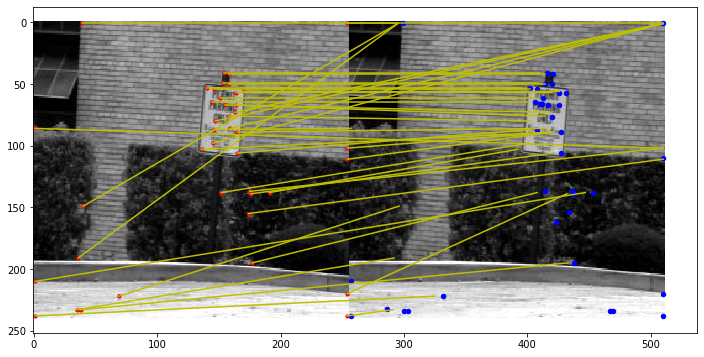

In [111]:
# FEATURE MATCHING
sigma=0.8; #Sigma controls the distance we are considering to look for similarity
plt.figure(figsize=(12,6))
D,match = spectral_matching(sigma,patches1, patches2, corners1, corners2)
match_euclidean = show_match(match,corners1,corners2,img1, img2)

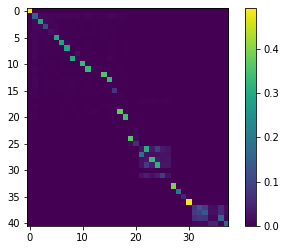

In [112]:
# LET US ALSO HAVE A LOOK AT THE AFFINITY MATRIX. 
plt.imshow(D) 
plt.colorbar()

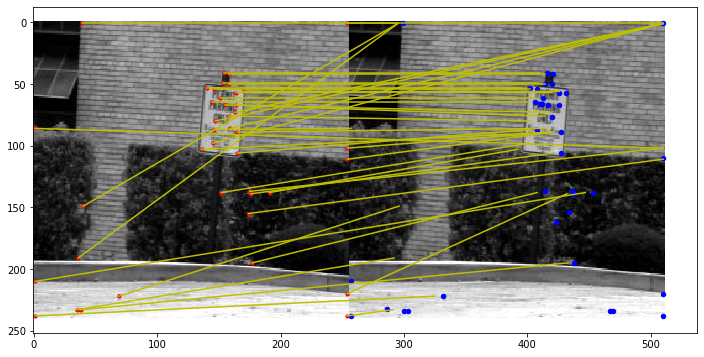

In [113]:
# FEATURE MATCHING
sigma=10; 
plt.figure(figsize=(12,6))
D,match = spectral_matching(sigma,patches1, patches2, corners1, corners2)
match_euclidean = show_match(match,corners1,corners2,img1, img2)

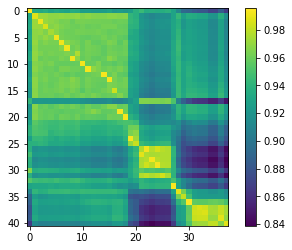

In [114]:
# LET US ALSO HAVE A LOOK AT THE AFFINITY MATRIX. 
plt.imshow(D) 
plt.colorbar()

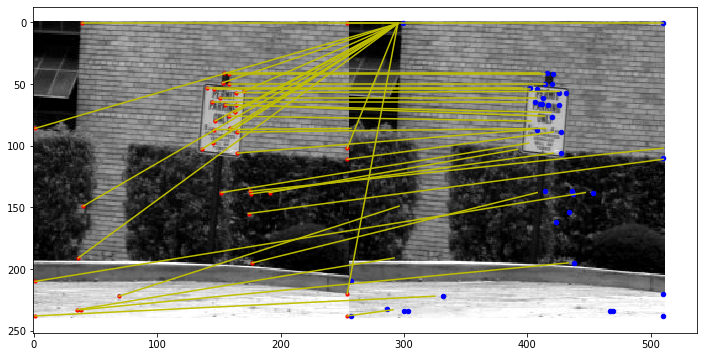

In [115]:
# FEATURE MATCHING
sigma= 0.05; 
plt.figure(figsize=(12,6))
D,match = spectral_matching(sigma,patches1, patches2, corners1, corners2)
match_euclidean = show_match(match,corners1,corners2,img1, img2)

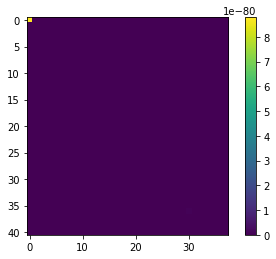

In [116]:
# LET US ALSO HAVE A LOOK AT THE AFFINITY MATRIX. 
plt.imshow(D) 
plt.colorbar()

##### I don't see much variation when sigma is increased beyond 0.8 to greater values or decreased a little. It shows some changes when the value is really close to zero.

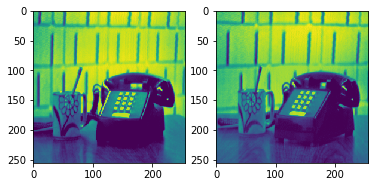

In [117]:
# LOAD IMAGES and turn them to gray
RGBimg1 = data.imread("images/phone1.png") ## FILL HERE
img1 = color.rgb2gray(RGBimg1) ## FILL HERE

RGBimg2 =data.imread("images/phone2.png") ## FILL HERE
img2 = color.rgb2gray(RGBimg2) ## FILL HERE


plt.subplot(1,2,1)
plt.imshow(img1)

plt.subplot(1,2,2)
plt.imshow(img2)

In [124]:
# FEATURE DESCRIPTORS
patches1 = patch_descriptor(img1, corners1, 40)
patches2 = patch_descriptor(img2, corners2, 40)

In [128]:
def spectral_matching(sigma, patches1, patches2,corner_pos1,corner_pos2):    
    # evaluate the distance among patches
    D = spatial.distance.cdist(patches1,patches2, metric='euclidean') 
    # compute the affinity matrix using the exponent formulation
    E = np.exp(-D/(2*sigma**2)) 
    # find the minimum distace
    argmaxE = np.argmax(E, axis=1)
    # plot the matching pairs
    match = corner_pos1[argmaxE,:]
#     print(E)
#     print(match)
    
    return E, match



In [130]:
def show_match(match,corner_pos1,corner_pos2,img1, img2):
    """show match on side-by-side images"""
    
    img= np.concatenate([img1,img2],axis=1)
    plt.imshow(img, cmap=cm.gist_gray)
    
    for i in range(0, len(corner_pos1)):
        plt.plot([corner_pos1[i,1], match[i,1]+img1.shape[1]], [corner_pos1[i,0], match[i,0]],'y')
        
    plt.scatter(corner_pos1[:,1], corner_pos1[:,0], s=10, c='r')
    plt.scatter(corner_pos2[:,1]+img1.shape[1], corner_pos2[:,0], s=20, c='b')
    
    return img    

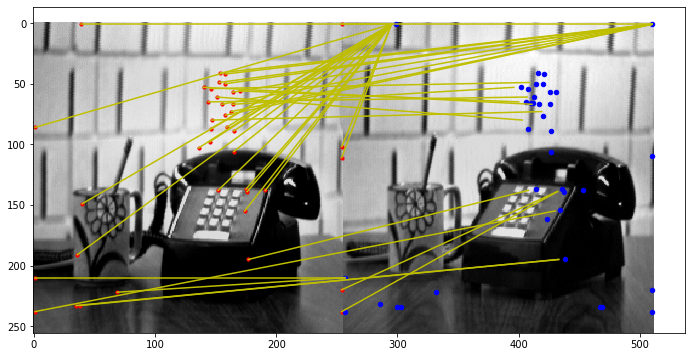

In [131]:
# FEATURE MATCHING
sigma=0.8; #Sigma controls the distance we are considering to look for similarity
plt.figure(figsize=(12,6))
D,match = spectral_matching(sigma,patches1, patches2, corners1, corners2)
match_euclidean = show_match(match,corners1,corners2,img1, img2)

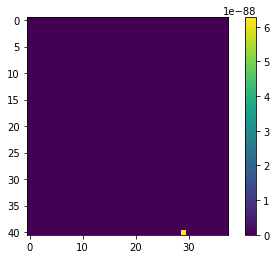

In [120]:
# LET US ALSO HAVE A LOOK AT THE AFFINITY MATRIX. 
plt.imshow(D) 
plt.colorbar()

In [121]:
def spectral_matchingg(sigma, patches1, patches2,corner_pos1,corner_pos2):    
    # evaluate the distance among patches
    D = spatial.distance.cdist(patches1,patches2, metric='euclidean') 
    # compute the affinity matrix using the exponent formulation
    E = np.exp(-D/(2*sigma**2)) 
    # find the minimum distace
    argmaxE = np.argmax(E, axis=1)
    # plot the matching pairs
    matchi = corner_pos1[argmaxE,:]
    matchj = corner_pos2[argmaxE,:]
    
#     print(E)
#     print(match)
    
    return E, matchi, matchj



In [122]:
def show_matchh(matchi,matchj,corner_pos1,corner_pos2,img1, img2):
    """show match on side-by-side images"""
    
    img= np.concatenate([img1,img2],axis=1)
    plt.imshow(img, cmap=cm.gist_gray)
    
    for i in range(0, len(corner_pos1)):
        plt.plot([corner_pos1[i,1], matchi[i,1]+img1.shape[0]], [corner_pos1[i,0], matchi[i,0]],'y')
    for i in range(0, len(corner_pos2)):
        plt.plot([corner_pos2[i,1], matchj[i,1]+img1.shape[1]], [corner_pos2[i,0], matchj[i,0]],'c')
        
    plt.scatter(corner_pos1[:,1], corner_pos1[:,0], s=10, c='r')
    plt.scatter(corner_pos2[:,1]+img1.shape[1], corner_pos2[:,0], s=20, c='b')
    
    return img    

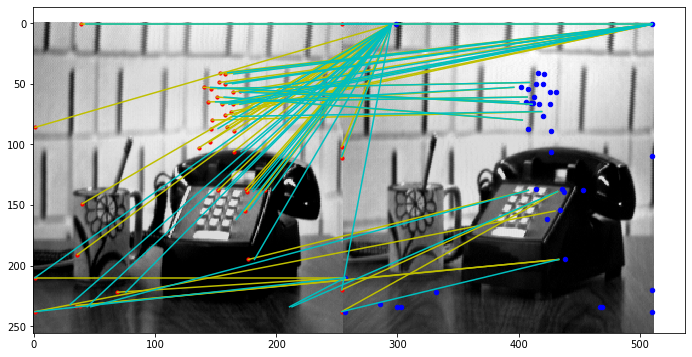

In [123]:
# FEATURE MATCHING
sigma=0.8; #Sigma controls the distance we are considering to look for similarity
plt.figure(figsize=(12,6))
D,match = spectral_matching(sigma,patches1, patches2, corners1, corners2)
match_euclidean = show_match(match,corners1,corners2,img1, img2)

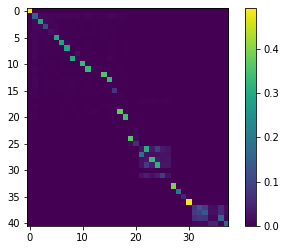

In [71]:
# LET US ALSO HAVE A LOOK AT THE AFFINITY MATRIX. 
plt.imshow(D) 
plt.colorbar()

#### I tried doing it with several other methods but kept getting an error about too many indices for show match function. I couldn't go about it so I settled for this.
From what I understood both rows and columns need to be evaluated for a value which is max in the column as well as the rows.

In [55]:
# def spectral_matchingg(sigma, patches1, patches2,corner_pos1,corner_pos2):    
# #     evaluate the distance among patches
#     Er=[]
#     Ec = []
#     D = spatial.distance.cdist(patches1,patches2, metric='sqeuclidean') ### FILL HERE (see the Hint above)
#     # compute the affinity matrix using the exponent formulation
#     for i in range(0, D.shape[0]-1):
#         for j in range(0, D.shape[1]-1):
#             Ei = np.exp(-D[i][j]/2*(sigma**2))
#             Er.append(Ei)      ### 
# #     print(Er)
# #     print(" ")
#     for j in range(0, D.shape[1]-1):
#         for i in range(0, D.shape[0]-1):
#             Ej = np.exp(-D[i][j]/2*(sigma**2))
#             Ec.append(Ej)
# #     print(Ec)
# #     print(" ")
# #     if np.argmax(Er, axis=0) == np.argmax(Ec, axis=0):
# #         argmaxE = np.argmax(Er, axis=0)
# # #         argmaxEj = np.argmax(E[j], axis=1)
#     # plot the matching pairs
#     matchr = corner_pos1[np.argmax(Er),:]
#     matchc = corner_pos2[np.argmax(Ec),:]
# #     match = np.argmax(matchr, matchc) 
#     E = Er + Ec
# #     print(E)
# #     print(Ej)
    
#     return E, matchr, matchc


In [57]:
# def spectral_matchingg(sigma, patches1, patches2,corner_pos1,corner_pos2):    
#     # evaluate the distance among patches
#     D = spatial.distance.cdist(patches1,patches2, metric='euclidean') ### FILL HERE (see the Hint above)
#     # compute the affinity matrix using the exponent formulation
#     for i in range(0, D.shape[0]-1):
#         Ei = np.exp(-D[i]/2*(sigma**2))
#     argmaxEi = np.argmax(Ei, axis=0)
#     for j in range(0, D.shape[1]-1):
#         Ej = np.exp(-D[j]/(2*sigma**2)) ### FILL HERE (see the Hint above)
#     # find the minimum distace
#     argmaxEj = np.argmax(Ej, axis=0)
#     # plot the matching pairs
#     matchi = corner_pos1[argmaxEi,:]
#     matchj = corner_pos2[argmaxEj,:]
#     E= [Ei + Ej]
# #     print(E)
# #     print(match)
    
#     return E, matchi, matchj



In [63]:
# def spectral_matchingg(sigma, patches1, patches2,corner_pos1,corner_pos2):    
# #     evaluate the distance among patches
#     Er=[]
#     Ec = []
#     D = spatial.distance.cdist(patches1,patches2, metric='sqeuclidean') ### FILL HERE (see the Hint above)
#     # compute the affinity matrix using the exponent formulation
#     for i in range(0, D.shape[0]-1):
#         for j in range(0, D.shape[1]-1):
#             Ei = np.exp(-D[i][j]/2*(sigma**2))
#             Er.append(Ei)      ### 
#     for j in range(0, D.shape[1]-1):
#         for i in range(0, D.shape[0]-1):
#             Ej = np.exp(-D[i][j]/2*(sigma**2))
#             Ec.append(Ej)
#     if np.exp(-D/(2*sigma**2)) < 2:
#         E = np.exp(-D/(2*sigma**2))
#     else:
#         E = 0

#            # plot the matching pairs
#     match = corner_pos1[argmaxE,:]
# #     print(E)
    
#     return E, match

### Analysis
It is important you try to understand the implementation tricks but also the underlying theory.
To be sure you fully grasp the concepts, you should try out other image pairs (see the Images folder)

### Improvements
There are a number of improvement you could consider at some point. Below you find a mandatory improvement and some optional ones
1.  The function spectral_matching does not compute the maxima in the correct way; correct the function so that the identified feature pairs are maxima of both rows and colums . 

Optionally you may also have a look at the following
1. spectral_matching: you may add a threshold on the distance, setting to 0 the affinity matrix entries below a threshold(see theory)
2. In the affinity matrix computation, one could also include an evaluation on the position of features (close features should be favoured if we have a prior on image similarity). Again, see theory
2. Corners on the border of the image should be discarded as they tend to be less reliable.


## Enforcing one-to-one matches
Below you find some code to compute the SVD of the Affinity matrix and use it to enhance the weak matches. You may try to use it if you want and see how the results change on the various examples

(41, 38)
(41, 41)
(38,)
(38, 38)


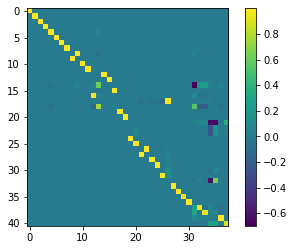

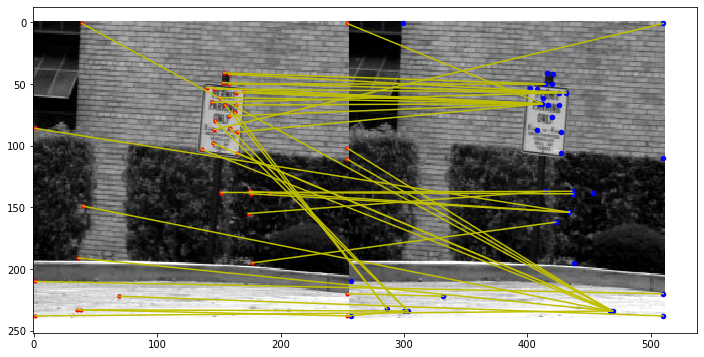

In [90]:
# LET US TRY TO ENFORCE ONE TO ONE MATCHES WITH THE SPECTRAL APPROACH
u, s, vh = np.linalg.svd(D, full_matrices=True)
print(np.shape(D))
print(np.shape(u))
print(np.shape(s))
print(np.shape(vh))
np.allclose(D, np.dot(u[:, :38] , vh))
A= np.dot(u[:, :38] , vh)
plt.imshow(A)
plt.colorbar()
argminD = np.argmin(A, axis=1)
# plot the matching pairs
match = corners2[argminD,:]
plt.figure(figsize=(12,6))
match_euclidean = show_match(match,corners1,corners2,img1, img2)